# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from tqdm import tqdm

In [2]:
np.random.seed(42)

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [3]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [5]:
train_loader.dataset.data.shape

(73257, 3, 32, 32)

In [6]:
len(train_sampler.indices)

58606

In [7]:
len(val_sampler.indices)

14651

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [8]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [9]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [10]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in tqdm(range(num_epochs)):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    accuracy = float(correct_samples) / total_samples

    return accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

 33%|███▎      | 1/3 [00:04<00:09,  4.56s/it]

Average loss: 1.809767, Train accuracy: 0.421988, Val accuracy: 0.557505


 67%|██████▋   | 2/3 [00:09<00:04,  4.51s/it]

Average loss: 1.454335, Train accuracy: 0.582858, Val accuracy: 0.599208


100%|██████████| 3/3 [00:13<00:00,  4.55s/it]

Average loss: 1.381811, Train accuracy: 0.616831, Val accuracy: 0.619548


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [11]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
       Flattener(),
       nn.Linear(3*32*32, 100),
       nn.ReLU(inplace=True),
       nn.Linear(100, 100), 
       nn.ReLU(inplace=True),
       nn.Linear(100, 10), 
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

 20%|██        | 1/5 [00:04<00:18,  4.59s/it]

Average loss: 2.181565, Train accuracy: 0.194605, Val accuracy: 0.225991


 40%|████      | 2/5 [00:09<00:13,  4.60s/it]

Average loss: 2.005932, Train accuracy: 0.275825, Val accuracy: 0.324142


 60%|██████    | 3/5 [00:13<00:09,  4.59s/it]

Average loss: 1.813916, Train accuracy: 0.369450, Val accuracy: 0.391236


 80%|████████  | 4/5 [00:18<00:04,  4.58s/it]

Average loss: 1.715104, Train accuracy: 0.417022, Val accuracy: 0.403249


100%|██████████| 5/5 [00:22<00:00,  4.58s/it]

Average loss: 1.685485, Train accuracy: 0.430007, Val accuracy: 0.426456


Добавьте слой с Batch Normalization

In [12]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(100),
        nn.Linear(100, 100), 
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(100),
        nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

 20%|██        | 1/5 [00:05<00:22,  5.54s/it]

Average loss: 1.916352, Train accuracy: 0.386991, Val accuracy: 0.539690


 40%|████      | 2/5 [00:11<00:16,  5.61s/it]

Average loss: 1.497647, Train accuracy: 0.591083, Val accuracy: 0.637567


 60%|██████    | 3/5 [00:17<00:11,  5.70s/it]

Average loss: 1.324888, Train accuracy: 0.647579, Val accuracy: 0.658863


 80%|████████  | 4/5 [00:22<00:05,  5.71s/it]

Average loss: 1.225643, Train accuracy: 0.676228, Val accuracy: 0.684527


100%|██████████| 5/5 [00:28<00:00,  5.67s/it]

Average loss: 1.164080, Train accuracy: 0.694553, Val accuracy: 0.719678


Добавьте уменьшение скорости обучения по ходу тренировки.

In [76]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model_modefied(model, train_loader, val_loader, loss, num_epochs, lr, weight_decay):    
    loss_history = []
    train_history = []
    val_history = []

    for epoch in tqdm(range(num_epochs)):
        if epoch != 0 and epoch % 2 == 0:
            lr /= 2 
        optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=weight_decay)

        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        

In [14]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(100),
        nn.Linear(100, 100), 
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(100),
        nn.Linear(100, 10), 
    )

loss_history, train_history, val_history = train_model_modefied(nn_model, train_loader, val_loader, loss, 5, lr=1e-3, weight_decay=1e-1)

 20%|██        | 1/5 [00:05<00:22,  5.65s/it]

Average loss: 1.911417, Train accuracy: 0.385694, Val accuracy: 0.559347


 40%|████      | 2/5 [00:11<00:16,  5.65s/it]

Average loss: 1.488179, Train accuracy: 0.601969, Val accuracy: 0.638045


 60%|██████    | 3/5 [00:16<00:11,  5.64s/it]

Average loss: 1.328297, Train accuracy: 0.663294, Val accuracy: 0.685209


 80%|████████  | 4/5 [00:22<00:05,  5.65s/it]

Average loss: 1.262100, Train accuracy: 0.679862, Val accuracy: 0.693878


100%|██████████| 5/5 [00:28<00:00,  5.65s/it]

Average loss: 1.210170, Train accuracy: 0.696362, Val accuracy: 0.712170


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [40]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    subset_sampler = SubsetSampler(indices)
    predictions, ground_truth = np.zeros(len(subset_sampler), int), np.zeros(len(subset_sampler), int)

    for num, indices in enumerate(subset_sampler):
        tensor = data_train[indices][0]
        tensor = tensor[None, :, :, :]
        pred = model(tensor)
        _, pred = torch.max(pred, 1)
    
        gr_tr = dataset[indices][1]
        predictions[num] = pred
        ground_truth[num] = gr_tr
        
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

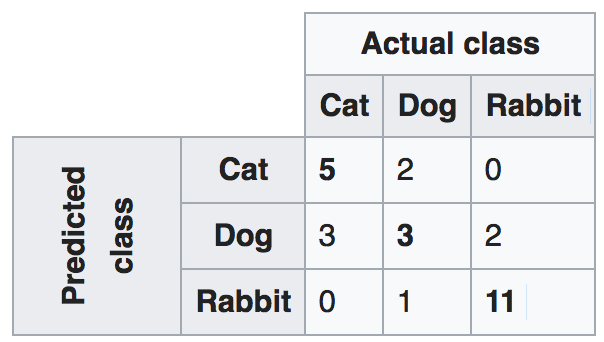

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

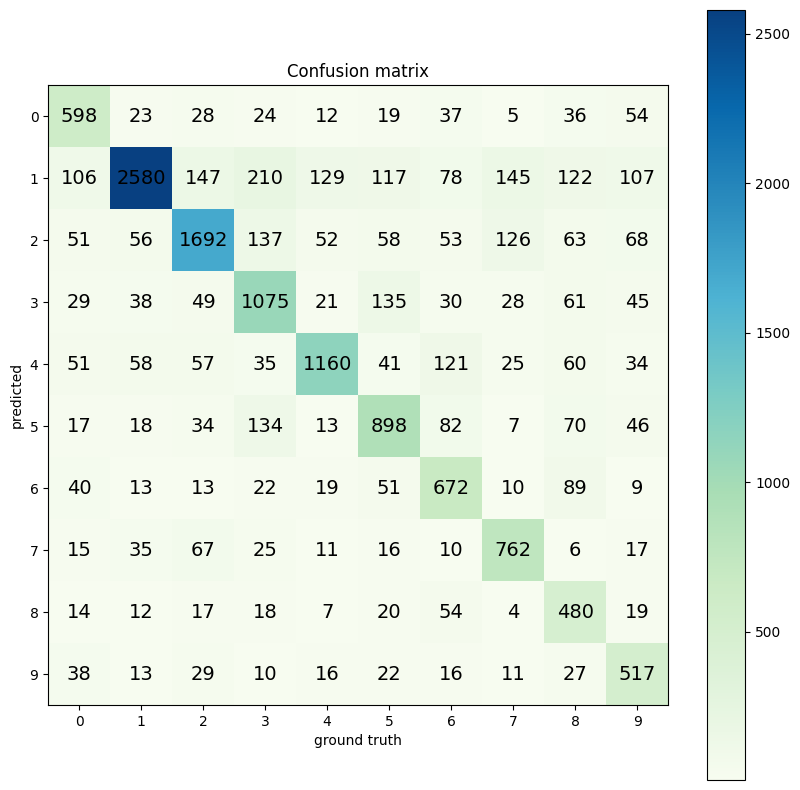

In [42]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), int)
    N = len(predictions)
    for idx in range(N):
        confusion_matrix[predictions[idx]][ground_truth[idx]] += 1

    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

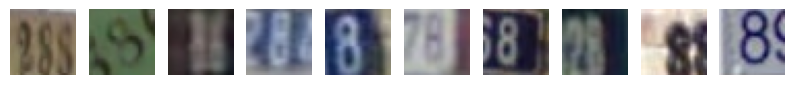

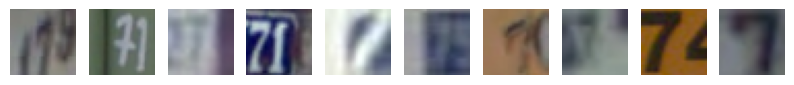

In [73]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    pred_class_subset = np.where(predicted_class == predictions)
    gt_class_subset = np.where(gt_class == groud_truth)

    intersected_indices = np.intersect1d(gt_class_subset, pred_class_subset)
    need_indices = val_indices[intersected_indices]
    visualize_images(need_indices, data)


visualize_predicted_actual(1, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [83]:
nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(100),
        nn.Linear(100, 100), 
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(100),
        nn.Linear(100, 100), 
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(100),
        nn.Linear(100, 10), 
    )

In [84]:
loss_history, train_history, val_history = train_model_modefied(nn_model, train_loader, val_loader, loss, 20, lr=1e-3, weight_decay=1e-1)

  5%|▌         | 1/20 [00:06<02:01,  6.40s/it]

Average loss: 1.899155, Train accuracy: 0.373460, Val accuracy: 0.541874


 10%|█         | 2/20 [00:12<01:54,  6.34s/it]

Average loss: 1.460349, Train accuracy: 0.585128, Val accuracy: 0.628831


 15%|█▌        | 3/20 [00:18<01:46,  6.24s/it]

Average loss: 1.297149, Train accuracy: 0.647118, Val accuracy: 0.676336


 20%|██        | 4/20 [00:25<01:41,  6.31s/it]

Average loss: 1.228904, Train accuracy: 0.668652, Val accuracy: 0.687120


 25%|██▌       | 5/20 [00:31<01:35,  6.34s/it]

Average loss: 1.168275, Train accuracy: 0.691772, Val accuracy: 0.701590


 30%|███       | 6/20 [00:37<01:27,  6.28s/it]

Average loss: 1.141661, Train accuracy: 0.700867, Val accuracy: 0.711283


 35%|███▌      | 7/20 [00:44<01:22,  6.33s/it]

Average loss: 1.117547, Train accuracy: 0.708460, Val accuracy: 0.721111


 40%|████      | 8/20 [00:50<01:15,  6.33s/it]

Average loss: 1.101188, Train accuracy: 0.714193, Val accuracy: 0.719883


 45%|████▌     | 9/20 [00:56<01:08,  6.27s/it]

Average loss: 1.087788, Train accuracy: 0.718715, Val accuracy: 0.729097


 50%|█████     | 10/20 [01:02<01:02,  6.24s/it]

Average loss: 1.082483, Train accuracy: 0.719261, Val accuracy: 0.725889


 55%|█████▌    | 11/20 [01:08<00:55,  6.20s/it]

Average loss: 1.074758, Train accuracy: 0.723339, Val accuracy: 0.730121


 60%|██████    | 12/20 [01:15<00:49,  6.19s/it]

Average loss: 1.073065, Train accuracy: 0.721991, Val accuracy: 0.729984


 65%|██████▌   | 13/20 [01:21<00:43,  6.18s/it]

Average loss: 1.066150, Train accuracy: 0.727502, Val accuracy: 0.734353


 70%|███████   | 14/20 [01:27<00:37,  6.17s/it]

Average loss: 1.065659, Train accuracy: 0.726956, Val accuracy: 0.730462


 75%|███████▌  | 15/20 [01:33<00:30,  6.16s/it]

Average loss: 1.064474, Train accuracy: 0.727127, Val accuracy: 0.731281


 80%|████████  | 16/20 [01:39<00:24,  6.16s/it]

Average loss: 1.063367, Train accuracy: 0.725950, Val accuracy: 0.733397


 85%|████████▌ | 17/20 [01:45<00:18,  6.15s/it]

Average loss: 1.062893, Train accuracy: 0.726547, Val accuracy: 0.732851


 90%|█████████ | 18/20 [01:52<00:12,  6.15s/it]

Average loss: 1.063442, Train accuracy: 0.725489, Val accuracy: 0.733807


 95%|█████████▌| 19/20 [01:58<00:06,  6.17s/it]

Average loss: 1.060710, Train accuracy: 0.726786, Val accuracy: 0.733261


100%|██████████| 20/20 [02:04<00:00,  6.22s/it]

Average loss: 1.062036, Train accuracy: 0.727673, Val accuracy: 0.730189


In [85]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.6989


In [107]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model_modefied(model, train_loader, val_loader, loss, num_epochs, lr, weight_decay, lr_freq):    
    loss_history = []
    train_history = []
    val_history = []

    for epoch in tqdm(range(num_epochs)):

        if epoch != 0 and epoch % lr_freq == 0:
            lr /= 2 
        optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=weight_decay)

        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        # print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return train_history[-1], val_history[-1]
        

In [108]:
lrs = [0.01, 0.001, 0.1]
weight_decays = [0.1, 1, 10]
lr_freqs = [1, 2, 3]
epochs_num = [5]

In [110]:
metrics_dict = {}
for lr in lrs:
    for weight_decay in weight_decays:
        for lr_freq in lr_freqs:
            for epochs in epochs_num:
                nn_model = nn.Sequential(
                    Flattener(),
                    nn.Linear(3*32*32, 100),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm1d(100),
                    nn.Linear(100, 100), 
                    nn.ReLU(inplace=True),
                    nn.BatchNorm1d(100),
                    nn.Linear(100, 100), 
                    nn.ReLU(inplace=True),
                    nn.BatchNorm1d(100),
                    nn.Linear(100, 10), 
                )
                train_history, val_history = train_model_modefied(
                    nn_model, 
                    train_loader, 
                    val_loader, 
                    loss, 
                    num_epochs=epochs, 
                    lr=lr,
                    weight_decay=weight_decay, 
                    lr_freq=lr_freq
                )
                print(f"lr={lr}, weight_decay={weight_decay}, lr_freq={lr_freq}, epochs= {epochs}")
                print("Train accuracy: %f, Val accuracy: %f" % (train_history, val_history))
                metrics_dict[(lr, weight_decay, lr_freq, epochs)] = (train_history, val_history)

100%|██████████| 5/5 [00:31<00:00,  6.30s/it]


lr=0.01, weight_decay=0.1, lr_freq=1, epochs= 5
Train accuracy: 0.771491, Val accuracy: 0.781244


100%|██████████| 5/5 [00:32<00:00,  6.43s/it]


lr=0.01, weight_decay=0.1, lr_freq=2, epochs= 5
Train accuracy: 0.737535, Val accuracy: 0.693332


100%|██████████| 5/5 [00:30<00:00,  6.09s/it]


lr=0.01, weight_decay=0.1, lr_freq=3, epochs= 5
Train accuracy: 0.681773, Val accuracy: 0.672241


100%|██████████| 5/5 [00:30<00:00,  6.07s/it]


lr=0.01, weight_decay=1, lr_freq=1, epochs= 5
Train accuracy: 0.187950, Val accuracy: 0.194253


100%|██████████| 5/5 [00:30<00:00,  6.08s/it]


lr=0.01, weight_decay=1, lr_freq=2, epochs= 5
Train accuracy: 0.187950, Val accuracy: 0.194253


100%|██████████| 5/5 [00:31<00:00,  6.31s/it]


lr=0.01, weight_decay=1, lr_freq=3, epochs= 5
Train accuracy: 0.187950, Val accuracy: 0.194253


100%|██████████| 5/5 [00:32<00:00,  6.50s/it]


lr=0.01, weight_decay=10, lr_freq=1, epochs= 5
Train accuracy: 0.187950, Val accuracy: 0.194253


100%|██████████| 5/5 [00:31<00:00,  6.32s/it]


lr=0.01, weight_decay=10, lr_freq=2, epochs= 5
Train accuracy: 0.187950, Val accuracy: 0.194253


100%|██████████| 5/5 [00:31<00:00,  6.38s/it]


lr=0.01, weight_decay=10, lr_freq=3, epochs= 5
Train accuracy: 0.187950, Val accuracy: 0.194253


100%|██████████| 5/5 [00:32<00:00,  6.48s/it]


lr=0.001, weight_decay=0.1, lr_freq=1, epochs= 5
Train accuracy: 0.645531, Val accuracy: 0.663914


100%|██████████| 5/5 [00:32<00:00,  6.54s/it]


lr=0.001, weight_decay=0.1, lr_freq=2, epochs= 5
Train accuracy: 0.689622, Val accuracy: 0.706709


100%|██████████| 5/5 [00:31<00:00,  6.31s/it]


lr=0.001, weight_decay=0.1, lr_freq=3, epochs= 5
Train accuracy: 0.693888, Val accuracy: 0.700020


100%|██████████| 5/5 [00:32<00:00,  6.42s/it]


lr=0.001, weight_decay=1, lr_freq=1, epochs= 5
Train accuracy: 0.522114, Val accuracy: 0.528019


100%|██████████| 5/5 [00:32<00:00,  6.48s/it]


lr=0.001, weight_decay=1, lr_freq=2, epochs= 5
Train accuracy: 0.290141, Val accuracy: 0.278206


100%|██████████| 5/5 [00:32<00:00,  6.47s/it]


lr=0.001, weight_decay=1, lr_freq=3, epochs= 5
Train accuracy: 0.188735, Val accuracy: 0.194253


100%|██████████| 5/5 [00:32<00:00,  6.51s/it]


lr=0.001, weight_decay=10, lr_freq=1, epochs= 5
Train accuracy: 0.187950, Val accuracy: 0.194253


100%|██████████| 5/5 [00:32<00:00,  6.56s/it]


lr=0.001, weight_decay=10, lr_freq=2, epochs= 5
Train accuracy: 0.187950, Val accuracy: 0.194253


100%|██████████| 5/5 [00:32<00:00,  6.56s/it]


lr=0.001, weight_decay=10, lr_freq=3, epochs= 5
Train accuracy: 0.187950, Val accuracy: 0.194253


100%|██████████| 5/5 [00:32<00:00,  6.44s/it]


lr=0.1, weight_decay=0.1, lr_freq=1, epochs= 5
Train accuracy: 0.472017, Val accuracy: 0.499010


100%|██████████| 5/5 [00:31<00:00,  6.23s/it]


lr=0.1, weight_decay=0.1, lr_freq=2, epochs= 5
Train accuracy: 0.327253, Val accuracy: 0.363593


100%|██████████| 5/5 [00:31<00:00,  6.33s/it]


lr=0.1, weight_decay=0.1, lr_freq=3, epochs= 5
Train accuracy: 0.299014, Val accuracy: 0.293222


100%|██████████| 5/5 [00:32<00:00,  6.41s/it]


lr=0.1, weight_decay=1, lr_freq=1, epochs= 5
Train accuracy: 0.187950, Val accuracy: 0.194253


100%|██████████| 5/5 [00:31<00:00,  6.34s/it]


lr=0.1, weight_decay=1, lr_freq=2, epochs= 5
Train accuracy: 0.187950, Val accuracy: 0.194253


100%|██████████| 5/5 [00:31<00:00,  6.32s/it]


lr=0.1, weight_decay=1, lr_freq=3, epochs= 5
Train accuracy: 0.187950, Val accuracy: 0.194253


100%|██████████| 5/5 [00:30<00:00,  6.10s/it]


lr=0.1, weight_decay=10, lr_freq=1, epochs= 5
Train accuracy: 0.187950, Val accuracy: 0.194253


100%|██████████| 5/5 [00:30<00:00,  6.17s/it]


lr=0.1, weight_decay=10, lr_freq=2, epochs= 5
Train accuracy: 0.185408, Val accuracy: 0.194253


100%|██████████| 5/5 [00:31<00:00,  6.20s/it]

lr=0.1, weight_decay=10, lr_freq=3, epochs= 5
Train accuracy: 0.180169, Val accuracy: 0.115350


In [111]:
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),
    nn.Linear(100, 100), 
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),
    nn.Linear(100, 100), 
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10), 
)

In [112]:
lr=0.01
weight_decay=0.1
lr_freq=1
epochs= 5

In [113]:
batch_size = 64

data_size = data_train.data.shape[0]
indices = list(range(data_size))
np.random.shuffle(indices)
train_indices = indices

train_sampler = SubsetRandomSampler(train_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)


In [116]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def _train_model(model, train_loader, loss, num_epochs, lr, weight_decay, lr_freq):    
    loss_history = []
    train_history = []

    for epoch in tqdm(range(num_epochs)):

        if epoch != 0 and epoch % lr_freq == 0:
            lr /= 2 
        optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=weight_decay)

        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        
        print("Average loss: %f, Train accuracy: %f" % (ave_loss, train_accuracy))
        
    return loss_history, train_history
        

In [119]:
_train_model(
            nn_model,  
            train_loader, 
            loss, 
            num_epochs=20, 
            lr=lr,
            weight_decay=weight_decay, 
            lr_freq=lr_freq
)

  5%|▌         | 1/20 [00:06<02:12,  6.98s/it]

Average loss: 1.380320, Train accuracy: 0.638014


 10%|█         | 2/20 [00:13<02:03,  6.84s/it]

Average loss: 1.269619, Train accuracy: 0.700575


 15%|█▌        | 3/20 [00:20<01:56,  6.88s/it]

Average loss: 1.182005, Train accuracy: 0.739916


 20%|██        | 4/20 [00:27<01:48,  6.81s/it]

Average loss: 1.116425, Train accuracy: 0.770384


 25%|██▌       | 5/20 [00:33<01:41,  6.75s/it]

Average loss: 1.069695, Train accuracy: 0.791624


 30%|███       | 6/20 [00:40<01:33,  6.69s/it]

Average loss: 1.041126, Train accuracy: 0.804565


 35%|███▌      | 7/20 [00:47<01:26,  6.65s/it]

Average loss: 1.025388, Train accuracy: 0.812878


 40%|████      | 8/20 [00:54<01:21,  6.75s/it]

Average loss: 1.014579, Train accuracy: 0.818256


 45%|████▌     | 9/20 [01:00<01:14,  6.77s/it]

Average loss: 1.012324, Train accuracy: 0.819225


 50%|█████     | 10/20 [01:07<01:07,  6.70s/it]

Average loss: 1.008828, Train accuracy: 0.822392


 55%|█████▌    | 11/20 [01:13<00:59,  6.62s/it]

Average loss: 1.007454, Train accuracy: 0.821205


 60%|██████    | 12/20 [01:20<00:52,  6.57s/it]

Average loss: 1.008327, Train accuracy: 0.822788


 65%|██████▌   | 13/20 [01:26<00:45,  6.53s/it]

Average loss: 1.007230, Train accuracy: 0.821232


 70%|███████   | 14/20 [01:33<00:39,  6.50s/it]

Average loss: 1.006908, Train accuracy: 0.821983


 75%|███████▌  | 15/20 [01:39<00:32,  6.50s/it]

Average loss: 1.007027, Train accuracy: 0.821369


 80%|████████  | 16/20 [01:46<00:26,  6.50s/it]

Average loss: 1.006813, Train accuracy: 0.822051


 85%|████████▌ | 17/20 [01:52<00:19,  6.51s/it]

Average loss: 1.004747, Train accuracy: 0.825082


 90%|█████████ | 18/20 [01:59<00:13,  6.54s/it]

Average loss: 1.005717, Train accuracy: 0.823621


 95%|█████████▌| 19/20 [02:05<00:06,  6.56s/it]

Average loss: 1.005779, Train accuracy: 0.824044


100%|██████████| 20/20 [02:12<00:00,  6.63s/it]

Average loss: 1.005821, Train accuracy: 0.822870


([1.380319595336914,
  1.2696189880371094,
  1.182004690170288,
  1.1164252758026123,
  1.0696953535079956,
  1.0411264896392822,
  1.0253880023956299,
  1.0145787000656128,
  1.0123238563537598,
  1.008827567100525,
  1.0074543952941895,
  1.008326530456543,
  1.0072298049926758,
  1.0069080591201782,
  1.0070269107818604,
  1.006813406944275,
  1.0047471523284912,
  1.0057166814804077,
  1.0057791471481323,
  1.0058205127716064],
 [0.6380141146921113,
  0.7005746891082081,
  0.7399156394610754,
  0.7703837175969532,
  0.7916240086271619,
  0.8045647514913251,
  0.8128779502300122,
  0.818256275850772,
  0.8192254665083201,
  0.8223923993611532,
  0.8212047995413407,
  0.8227882659677573,
  0.8212321006866238,
  0.8219828821819075,
  0.821368606413039,
  0.8220511350451152,
  0.8250815621715331,
  0.8236209508988902,
  0.8240441186507774,
  0.8228701694036065])

In [120]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8043
